$$
\newcommand{\ped}[1]{_{\mathrm{#1}}}
\newcommand{\ap}[1]{^{\mathrm{#1}}}
\newcommand{\nvector}[1]{\mathbf{#1}}
\newcommand{\nmatrix}[1]{\mathit{#1}}
\newcommand{\unitvector}[1]{\hat{\nvector{e}}_{#1}}
\newcommand{\volume}{\mathcal{V}}
\newcommand{\average}[1]{\overline{#1}}
\newcommand{\rate}[1]{\dot{#1}}
\newcommand{\flux}[1]{{#1}''}
\newcommand{\curl}[1]{\nabla\times {#1}}
\newcommand{\curlv}[1]{\curl{\nvector{#1}}}
\newcommand{\divergent}[1]{\nabla \cdot #1}
\newcommand{\divergentv}[1]{\divergent{\nvector{#1}}}
\newcommand{\divergentpar}[1]{\divergent{\left( #1 \right)}}
\newcommand{\gradient}[1]{\nabla {#1}}
\newcommand{\gradientpar}[1]{\gradient{\left( {#1} \right)}}
\newcommand{\laplacian}[1]{\nabla^2 #1}
\newcommand{\laplacianpar}[1]{\laplacian{\left( #1 \right)}}
\newcommand{\vectornorm}[1]{\left\lVert #1 \right\rVert}
\newcommand{\diffp}[2]{\frac{\partial {#1}}{\partial {#2}}}
\newcommand{\diffps}[2]{\frac{\partial^2 {#1}}{\partial {#2}^2}}
\newcommand{\rvec}{\nvector{r}}
\newcommand{\nvh}{\nvector{H}}
\newcommand{\nvb}{\nvector{B}}
\newcommand{\nvrem}{\nvector{B}\ped{rem}}
\newcommand{\nvbrem}{\nvrem}
\newcommand{\nvm}{\nvector{M}}
\newcommand{\mur}{\mu\ped{r}}
\newcommand{\nvbremhat}{\hat{\nvector{B}}\ped{rem}}
\newcommand{\acoef}[2]{a_{{#1},\mathrm{#2}}}
\newcommand{\bcoef}[2]{b_{{#1},\mathrm{#2}}}
\newcommand{\Azexpr}[1]{A_{\mathrm{#1}\, z}}
\newcommand{\bremii}{B_{\mathrm{rem,II}}}
\newcommand{\bremiv}{B_{\mathrm{rem,IV}}}
\newcommand{\aIII}{\acoef{1}{III}}
\newcommand{\bIII}{\bcoef{1}{III}}
\newcommand{\nvbIII}{\nvector{B}\ped{III}}
\newcommand{\BIII}{B\ped{III}}
\newcommand{\diffd}[1]{\mathrm{d}\,{#1}}
$$

# Demonstration of the principle of superposition

Teslamax model:

<img src="figures/teslamax.png" width=500>

Tell the location of the TeslaMax Java class file:

In [1]:
from pathlib import Path
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import teslamax
from teslamax import TeslaMaxModel



mpl_params = {'text.usetex': True,
              'font.family': 'serif',
              'font.serif': 'Computer Modern',
              'text.latex.preamble': [r'\usepackage{engsymbols}',
                                      r'\usepackage{magref}',
                                      r'\usepackage{siunitx}']}
matplotlib.rcParams.update(mpl_params)


In [2]:
FIGSIZE_CM = 20
FIGSIZE_INCHES = FIGSIZE_CM / 2.54

FONTSIZE = 20

## Playground

In [3]:
os.chdir('C:\\Users\\fabiofortkamp\\code\\TeslaMax\\')

In [4]:
teslamax_playground = "teslamax-play"


In [5]:
os.getcwd()

'C:\\Users\\fabiofortkamp\\code\\TeslaMax'

### Magnetic Profile

In [6]:
param_dict = {"R_i": 0.015,
                "R_o": 0.070,
                "h_gap": 0.020,
                "R_s": 0.140,
                "h_fc": 0.010,
                "R_e": 2,
                "n_IV": 1,
                "alpha_rem_IV_1": 15,
                "phi_S_IV": 45,
                "n_II": 1,
                "alpha_rem_II_1": 15,
                "phi_C_II": 0,
                "phi_S_II": 45,
                "B_rem_II_1": 1.4,
                "mu_r_II": 1.05,
                "B_rem_IV_1": 1.4,
                "mu_r_IV": 1.05,
                "linear_iron": 1,
                "mu_r_iron": 5e3,
             }


In [7]:
tmm = TeslaMaxModel(params=param_dict,
                   path=teslamax_playground)

In [8]:
tmm.run(verbose=True)

*******************************************
***COMSOL 5.2.1.229 progress output file***
*******************************************
Thu Feb 09 09:43:11 BRST 2017
COMSOL 5.2a (Build: 229) starting in batch mode
Running: C:\Users\fabiofortkamp\code\teslamax\java\TeslaMax.class
           Current Progress:   0 % - Circle 1
Memory: 374/375 590/591
           Current Progress:   8 % - Circle 2
Memory: 366/386 580/603
-          Current Progress:  17 % - Difference 1
---------  Current Progress:  93 % - Resolving domains
Memory: 368/386 581/603
           Current Progress:   0 % - Circle 1
Memory: 372/386 585/603
           Current Progress:   8 % - Circle 2
-          Current Progress:  17 % - Difference 1
---------  Current Progress:  93 % - Resolving domains
Memory: 373/386 585/603
           Current Progress:   0 % - Cylinder Block - Iron II Wedge 1Q
Memory: 422/422 607/607
           Current Progress:   0 % - Circle 1
Memory: 427/427 607/607
           Current Progress:   0 % - Circle 2

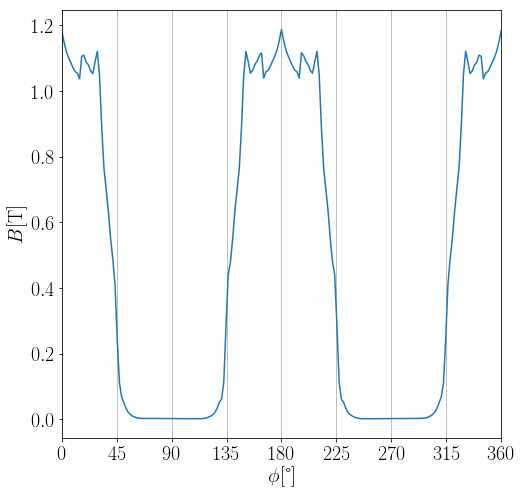

In [9]:
%matplotlib inline
plt.rc('font',size=FONTSIZE)

profile_fig = plt.figure(figsize=(FIGSIZE_INCHES,FIGSIZE_INCHES))
profile_axes = profile_fig.add_subplot(111)

phi_vector, B_vector = tmm.get_profile_data().T

profile_axes.plot(phi_vector,B_vector)
profile_axes.set_xlim(0,np.max(phi_vector))
profile_axes.set_xticks(np.linspace(0,np.max(phi_vector),9))
profile_axes.xaxis.grid(True)
profile_axes.set_xlabel(r'$\phi [\si{\degree}]$')
profile_axes.set_ylabel(r'$B [\si{\tesla}]$')


### Magnet profile - comparison between linear and non-linear iron regions

In [ ]:
param_dict_linear_5000 = {"R_i": 0.015,
                "R_o": 0.070,
                "h_gap": 0.020,
                "R_s": 0.140,
                "h_fc": 0.010,
                "R_e": 2,
                "n_IV": 3,
                "alpha_rem_IV_1": 15,
                "alpha_rem_IV_2": 45,
                "alpha_rem_IV_3": 135,
                "phi_S_IV": 45,
                "n_II": 3,
                "alpha_rem_II_1": 15,
                "alpha_rem_II_2": 30,
                "alpha_rem_II_3": 45,
                "phi_C_II": 15,
                "phi_S_II": 45,
                "B_rem_II_1": 1.4,
                "B_rem_II_2": 1.4,
                "B_rem_II_3": 1.4,
                "mu_r_II": 1.05,
                "B_rem_IV_1": 1.4,
                "B_rem_IV_2": 1.4,
                "B_rem_IV_3": 1.4,
                "mu_r_IV": 1.05,
              "linear_iron": 1,
              "mu_r_iron": 5e3,
             }

param_dict_non_linear = param_dict_linear_5000.copy()
param_dict_non_linear["linear_iron"] = 0

param_dict_linear_1000 = param_dict_linear_5000.copy()
param_dict_linear_1000["mu_r_iron"] = 1e3



In [ ]:
tmm_linear_5000 = TeslaMaxModel(params=param_dict_linear_5000,
                               path=teslamax_playground)
tmm_linear_5000.run()

phi_vector_linear_5000, B_vector_linear_5000 = tmm_linear_5000.get_profile_data().T


In [ ]:
tmm_linear_1000 = TeslaMaxModel(params=param_dict_linear_1000,
                               path=teslamax_playground)
tmm_linear_1000.run()

phi_vector_linear_1000, B_vector_linear_1000 = tmm_linear_1000.get_profile_data().T


In [ ]:
tmm_non_linear = TeslaMaxModel(params=param_dict_non_linear,
                               path=teslamax_playground)
tmm_non_linear.run()

phi_vector_non_linear, B_vector_non_linear = tmm_non_linear.get_profile_data().T


In [ ]:
%matplotlib inline
plt.rc('font',size=FONTSIZE)

profile_fig = plt.figure(figsize=(FIGSIZE_INCHES,FIGSIZE_INCHES))
profile_axes = profile_fig.add_subplot(111)

profile_axes.plot(phi_vector_linear_5000,B_vector_linear_5000,label="Linear 5000")
profile_axes.plot(phi_vector_linear_1000,B_vector_linear_1000,label="Linear 1000")
profile_axes.plot(phi_vector_non_linear,B_vector_non_linear,label="Non-linear")

profile_axes.set_xlim(0,np.max(phi_vector))
profile_axes.set_xticks(np.linspace(0,np.max(phi_vector),9))
profile_axes.xaxis.grid(True)
profile_axes.set_xlabel(r'$\phi [\si{\degree}]$')
profile_axes.set_ylabel(r'$B [\si{\tesla}]$')
profile_axes.legend(loc='best')


### Magnet profile - comparison between iron and magnet core

In [ ]:
param_dict_magnet = {"R_i": 0.015,
                "R_o": 0.070,
                "h_gap": 0.020,
                "R_s": 0.140,
                "h_fc": 0.020,
                "R_e": 2,
                "n_IV": 3,
                "alpha_rem_IV_1": 15,
                "alpha_rem_IV_2": 45,
                "alpha_rem_IV_3": 75,
                "phi_S_IV": 45,
                "n_II": 2,
                "alpha_rem_II_1": -45,
                "alpha_rem_II_2": -45,
                "phi_C_II": 15,
                "phi_S_II": 45,
                 "B_rem_II_1": 1.4,
                "B_rem_II_2": 1.4,
                "B_rem_II_3": 1.4,
                "mu_r_II": 1.05,
                "B_rem_IV_1": 1.4,
                "B_rem_IV_2": 1.4,
                "B_rem_IV_3": 1.4,
                "mu_r_IV": 1.05,
                "linear_iron": 0
             }

param_dict_iron = param_dict_magnet.copy()
param_dict_iron["n_II"] = 0
param_dict_iron["phi_C_II"] = 0
param_dict_iron["phi_S_II"] = 0



In [ ]:
tmm_magnet = TeslaMaxModel(params=param_dict_magnet,
                          path=teslamax_playground)
tmm_magnet.run(verbose=True)
phi_vector_magnet, B_vector_magnet = tmm_magnet.get_profile_data().T

In [ ]:
tmm_iron = TeslaMaxModel(params=param_dict_iron,
                          path=teslamax_playground)
tmm_iron.run()
phi_vector_iron, B_vector_iron = tmm_iron.get_profile_data().T

In [ ]:
B_vector_iron - B_vector_iron

In [ ]:
%matplotlib inline
plt.rc('font',size=FONTSIZE)

profile_fig = plt.figure(figsize=(FIGSIZE_INCHES,FIGSIZE_INCHES))
profile_axes = profile_fig.add_subplot(111)

profile_axes.plot(phi_vector_magnet,B_vector_magnet,label="Magnet")
profile_axes.plot(phi_vector_iron,B_vector_iron,label="Iron")
profile_axes.set_xlim(0,np.max(phi_vector))
profile_axes.set_xticks(np.linspace(0,np.max(phi_vector),9))
profile_axes.xaxis.grid(True)
profile_axes.set_xlabel(r'$\phi [\si{\degree}]$')
profile_axes.set_ylabel(r'$B [\si{\tesla}]$')
profile_axes.legend(loc='best')
